![RISE MICCAI LOGO](https://summer.rise-miccai.org/resources/images/logo.png)

# Day 2 MRI Quality Assessment: Multi-Task Classification

## **Learning Objectives**

By the end of this notebook, you will understand:

1. **Medical Image Analysis Fundamentals**
   - How to load and visualize MRI data in NIfTI format
   - Understanding different MRI orientations (axial, coronal, sagittal)
   - Quality assessment metrics for medical imaging

2. **Deep Learning for Medical Images**
   - Building 3D CNNs for volumetric data
   - Multi-label classification for quality assessment
   - Medical image preprocessing and augmentation techniques

3. **Practical ML Pipeline Development**
   - Patient-level data splitting to prevent data leakage
   - Comprehensive model evaluation with medical-specific metrics
   - Handling class imbalance in medical datasets

4. **Research Methodology**
   - F1, F2, precision, recall metrics in medical context
   - Proper experimental design for clinical applications
   - Result interpretation and clinical relevance

## **Clinical Context: Why MRI Quality Assessment Matters**

**The Challenge:**
- Low-field MRI systems (0.064T) make healthcare more accessible but produce images with various artifacts
- Manual quality assessment is time-consuming and subjective
- Automated quality control can improve clinical workflow efficiency

**Our Solution:**
- Develop an AI system to automatically detect 7 types of image artifacts
- Use deep learning to classify artifact severity (0=none, 1=mild, 2=severe)
- Enable real-time quality feedback during MRI acquisition

## **Dataset Overview: LISA (Low-field Image quality Assessment)**

**Technical Specifications:**
- **Field Strength**: 0.064T (Hyperfine SWOOP system)
- **Sequence**: Spin Echo (TR=1.5s, TE=5ms, TI=400ms)
- **Sites**: Multi-center data from Uganda, South Africa, USA
- **Format**: NIfTI (.nii.gz) with CSV quality labels

**Quality Categories We'll Assess:**
1. **Noise** - Random signal variations
2. **Zipper** - Radiofrequency interference artifacts
3. **Positioning** - Patient positioning issues
4. **Banding** - Intensity variation artifacts
5. **Motion** - Patient movement during scan
6. **Contrast** - Image contrast problems
7. **Distortion** - Geometric distortions

## **What We'll Accomplish**

1. **Exploratory Data Analysis**: Understand data distribution and quality patterns
2. **Advanced Preprocessing**: Medical image normalization and augmentation
3. **Model Architecture**: Design 3D CNN for multi-label classification
4. **Training Pipeline**: Implement robust training with early stopping
5. **Comprehensive Evaluation**: Medical-grade performance assessment
6. **Clinical Interpretation**: Understand results in clinical context

---

**Think About This**: How might automated quality assessment change the workflow in a busy radiology department? What are the potential benefits and risks?

## 1. Environment Setup and Imports


**Medical Imaging Libraries:**
- **`nibabel`**: The standard Python library for reading neuroimaging data (NIfTI format)
- **`MONAI`**: Medical Open Network for AI - specialized transforms for medical images
- **`monai.networks.nets`**: Pre-built, medical-optimized network architectures
- **`matplotlib/seaborn`**: Visualization tools optimized for medical data

**Deep Learning Stack:**
- **`PyTorch`**: Flexible framework ideal for research and custom architectures
- **`scikit-learn`**: Robust evaluation metrics and data splitting utilities


### **Multi-Task Learning Strategy**

**Why Add Orientation Prediction?**
- **Spatial Understanding**: Helps model learn anatomical structure
- **Regularization**: Auxiliary task prevents overfitting
- **Clinical Relevance**: Orientation awareness improves spatial reasoning
- **Feature Sharing**: Common backbone benefits both tasks

### **Questions to Consider:**
1. How does using pre-trained medical networks compare to training from scratch?
2. What are the trade-offs between custom architectures and proven ones?
3. How does multi-task learning improve generalization in medical AI?
4. Why is orientation prediction a good auxiliary task for quality assessment?

In [ ]:
!pip install monai nibabel matplotlib pandas numpy scikit-learn torch torchvision

In [2]:
!wget https://mbzuaiac-my.sharepoint.com/:u:/g/personal/shahad_hardan_mbzuai_ac_ae/EYXD4QbhEk1CnKRQSS481MoBdocMNvV6gWNtb79qKUGIqA?download=1 -O LISA_Task_1.zip

--2025-07-09 15:28:37--  https://mbzuaiac-my.sharepoint.com/:u:/g/personal/shahad_hardan_mbzuai_ac_ae/EYXD4QbhEk1CnKRQSS481MoBdocMNvV6gWNtb79qKUGIqA?download=1
Resolving mbzuaiac-my.sharepoint.com (mbzuaiac-my.sharepoint.com)... 52.107.238.117, 52.107.252.132, 52.107.238.106, ...
Connecting to mbzuaiac-my.sharepoint.com (mbzuaiac-my.sharepoint.com)|52.107.238.117|:443... connected.
HTTP request sent, awaiting response... 302 
Location: /personal/shahad_hardan_mbzuai_ac_ae/Documents/Summer%20School%20-%20MICCAI/LISA/LISA_Task_1.zip?ga=1 [following]
--2025-07-09 15:28:38--  https://mbzuaiac-my.sharepoint.com/personal/shahad_hardan_mbzuai_ac_ae/Documents/Summer%20School%20-%20MICCAI/LISA/LISA_Task_1.zip?ga=1
Reusing existing connection to mbzuaiac-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 661072389 (630M) [application/x-zip-compressed]
Saving to: ‘LISA_Task_1.zip’

LISA_Task_1.zip     100%[===================>] 630.45M  67.1MB/s    in 9.9s    

2025-07-

In [ ]:
!unzip LISA_Task_1.zip -d ./LISA_Task_1

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Medical imaging
import nibabel as nib
import monai
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Spacingd, Orientationd,
    ScaleIntensityRanged, RandRotated, RandFlipd, RandZoomd,
    RandGaussianNoised, RandAdjustContrastd, Resized, ToTensord,
)

from monai.transforms import Transform, RandRotated
from monai.data import DataLoader, Dataset
import monai.networks.nets as nets

# Deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, fbeta_score

def set_seed(seed: int) -> None:
    print(f"Set a random seed as {seed}.")

    os.environ["PYTHONHASHSEED"] = str(seed)  # os
    random.seed(seed)  # random
    np.random.seed(seed)  # numpy
    monai.utils.set_determinism(seed)  # monai

    # pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set random seed for reproducibility
set_seed(42)

Set a random seed as 42.


## 2. Data Exploration and Visualization

### **Understanding Our Dataset Structure**

**What We're Looking For:**
- How many images and patients do we have?
- What's the distribution of orientations (axial, coronal, sagittal)?
- Are all patients represented equally across orientations?
- What does the file naming convention tell us?

**File Naming Convention:**
- `LISA_XXXX_LF_orientation.nii.gz`
- `LISA_XXXX`: Patient identifier
- `LF`: Low Field indicator
- `orientation`: axi (axial), cor (coronal), sag (sagittal)

### **Key Questions We'll Answer:**
1. **Data Completeness**: Do all patients have all three orientations?
2. **Quality Distribution**: How are artifacts distributed across the dataset?
3. **Multi-center Effects**: Are there patterns by acquisition site?
4. **Class Balance**: Are some artifact types more common than others?

In [5]:
# Define paths
data_dir = Path('./LISA_Task_1')
csv_path = data_dir / 'LISA_LF_QC_2025.csv'

# Load the QC ratings CSV
df = pd.read_csv(csv_path)

print(f"Dataset shape: {df.shape}")
print(f"First few rows:")
print(df.head())

print(f"Columns: {df.columns.tolist()}")
print(f"Data types:")
print(df.dtypes)

Dataset shape: (532, 8)
First few rows:
                  filename  Noise  Zipper  Positioning  Banding  Motion  \
0  LISA_0001_LF_axi.nii.gz      0       0            0        0       0   
1  LISA_0001_LF_cor.nii.gz      0       0            0        0       0   
2  LISA_0001_LF_sag.nii.gz      0       0            0        0       0   
3  LISA_0002_LF_axi.nii.gz      0       0            0        0       0   
4  LISA_0002_LF_cor.nii.gz      0       0            0        0       0   

   Contrast  Distortion  
0         0           0  
1         0           0  
2         0           1  
3         0           0  
4         0           2  
Columns: ['filename', 'Noise', 'Zipper', 'Positioning', 'Banding', 'Motion', 'Contrast', 'Distortion']
Data types:
filename       object
Noise           int64
Zipper          int64
Positioning     int64
Banding         int64
Motion          int64
Contrast        int64
Distortion      int64
dtype: object


In [6]:
# Extract information from filenames
df['patient_id'] = df['filename'].str.extract(r'(LISA_\d+)_LF')
df['orientation'] = df['filename'].str.extract(r'LF_(\w+)\.nii\.gz')

# Check unique orientations and patient counts
print(f"Unique orientations: {df['orientation'].value_counts()}")
print(f"Number of unique patients: {df['patient_id'].nunique()}")
print(f"Total images: {len(df)}")

# Check orientation distribution
orientation_counts = df['orientation'].value_counts()
print(f"Orientation distribution:")
for orient, count in orientation_counts.items():
    print(f"  {orient}: {count} images")

# Analyze patient distribution
print(f"\nPatient distribution analysis:")
patient_orientation_counts = df.groupby('patient_id')['orientation'].nunique().value_counts().sort_index()
print(f"Patients with 1 orientation: {patient_orientation_counts.get(1, 0)}")
print(f"Patients with 2 orientations: {patient_orientation_counts.get(2, 0)}")
print(f"Patients with 3 orientations: {patient_orientation_counts.get(3, 0)}")


# Find patients with interesting quality score patterns
print(f"\nFinding patients with diverse quality scores...")
patients_with_high_scores = []
patients_with_mixed_scores = []

# Define artifact categories
artifact_categories = ['Noise', 'Zipper', 'Positioning', 'Banding', 'Motion', 'Contrast', 'Distortion']

for patient_id in df['patient_id'].unique():
    patient_data = df[df['patient_id'] == patient_id]
    max_scores = patient_data[artifact_categories].max()
    total_score = patient_data[artifact_categories].sum().sum()

    if max_scores.max() >= 2:  # Has at least one severe artifact
        patients_with_high_scores.append((patient_id, total_score))
    if total_score > 0 and total_score < 10:  # Has some artifacts but not too many
        patients_with_mixed_scores.append((patient_id, total_score))

# Sort by total score
patients_with_high_scores.sort(key=lambda x: x[1], reverse=True)
patients_with_mixed_scores.sort(key=lambda x: x[1], reverse=True)

print(f"Patients with severe artifacts (score=2): {len(patients_with_high_scores)}")
print(f"Patients with mixed quality scores: {len(patients_with_mixed_scores)}")

if patients_with_high_scores:
    print(f"Top patients with high artifact scores: {patients_with_high_scores[:5]}")
if patients_with_mixed_scores:
    print(f"Patients with mixed scores: {patients_with_mixed_scores[:5]}")

Unique orientations: orientation
cor    183
sag    176
axi    173
Name: count, dtype: int64
Number of unique patients: 244
Total images: 532
Orientation distribution:
  cor: 183 images
  sag: 176 images
  axi: 173 images

Patient distribution analysis:
Patients with 1 orientation: 100
Patients with 2 orientations: 0
Patients with 3 orientations: 144

Finding patients with diverse quality scores...
Patients with severe artifacts (score=2): 140
Patients with mixed quality scores: 221
Top patients with high artifact scores: [('LISA_0080', np.int64(14)), ('LISA_0083', np.int64(14)), ('LISA_0011', np.int64(13)), ('LISA_0069', np.int64(12)), ('LISA_0037', np.int64(11))]
Patients with mixed scores: [('LISA_0004', np.int64(9)), ('LISA_0064', np.int64(9)), ('LISA_1017', np.int64(9)), ('LISA_1001', np.int64(9)), ('LISA_1021', np.int64(9))]


### 2.1 Quality Score Distribution Analysis

### **Understanding Quality Scores**

**Quality Score Interpretation:**
- **Score 0**: No visible artifact - image is clinically acceptable
- **Score 1**: Mild artifact - noticeable but doesn't significantly impact diagnosis
- **Score 2**: Severe artifact - significantly impairs ability to distinguish neural structures

**Why This Matters:**
- Understanding class distribution helps us design appropriate loss functions
- Imbalanced datasets may require special handling (weighted losses, sampling strategies)
- Clinical impact varies by artifact type - some are more critical than others

### **Critical Thinking Questions:**
1. **Class Imbalance**: Which artifact types show the most imbalance? How might this affect training?
2. **Clinical Priority**: If you had to rank these artifacts by clinical importance, how would you do it?
3. **Quality Control**: What percentage of images would be considered "high quality" (mostly 0s)?
4. **Data Collection**: Why might some artifacts be more common in low-field MRI?

In [7]:
# Calculate statistics for each artifact category
print("Quality Score Statistics by Artifact Category:")
print("=" * 50)
for category in artifact_categories:
    counts = df[category].value_counts().sort_index()
    print(f"{category}:")
    print(f"  Score 0 (no artifact): {counts.get(0, 0)} ({counts.get(0, 0)/len(df)*100:.1f}%)")
    print(f"  Score 1 (mild artifact): {counts.get(1, 0)} ({counts.get(1, 0)/len(df)*100:.1f}%)")
    print(f"  Score 2 (severe artifact): {counts.get(2, 0)} ({counts.get(2, 0)/len(df)*100:.1f}%)")

Quality Score Statistics by Artifact Category:
Noise:
  Score 0 (no artifact): 426 (80.1%)
  Score 1 (mild artifact): 60 (11.3%)
  Score 2 (severe artifact): 46 (8.6%)
Zipper:
  Score 0 (no artifact): 398 (74.8%)
  Score 1 (mild artifact): 105 (19.7%)
  Score 2 (severe artifact): 29 (5.5%)
Positioning:
  Score 0 (no artifact): 470 (88.3%)
  Score 1 (mild artifact): 47 (8.8%)
  Score 2 (severe artifact): 15 (2.8%)
Banding:
  Score 0 (no artifact): 504 (94.7%)
  Score 1 (mild artifact): 15 (2.8%)
  Score 2 (severe artifact): 13 (2.4%)
Motion:
  Score 0 (no artifact): 384 (72.2%)
  Score 1 (mild artifact): 78 (14.7%)
  Score 2 (severe artifact): 70 (13.2%)
Contrast:
  Score 0 (no artifact): 375 (70.5%)
  Score 1 (mild artifact): 134 (25.2%)
  Score 2 (severe artifact): 23 (4.3%)
Distortion:
  Score 0 (no artifact): 435 (81.8%)
  Score 1 (mild artifact): 56 (10.5%)
  Score 2 (severe artifact): 41 (7.7%)


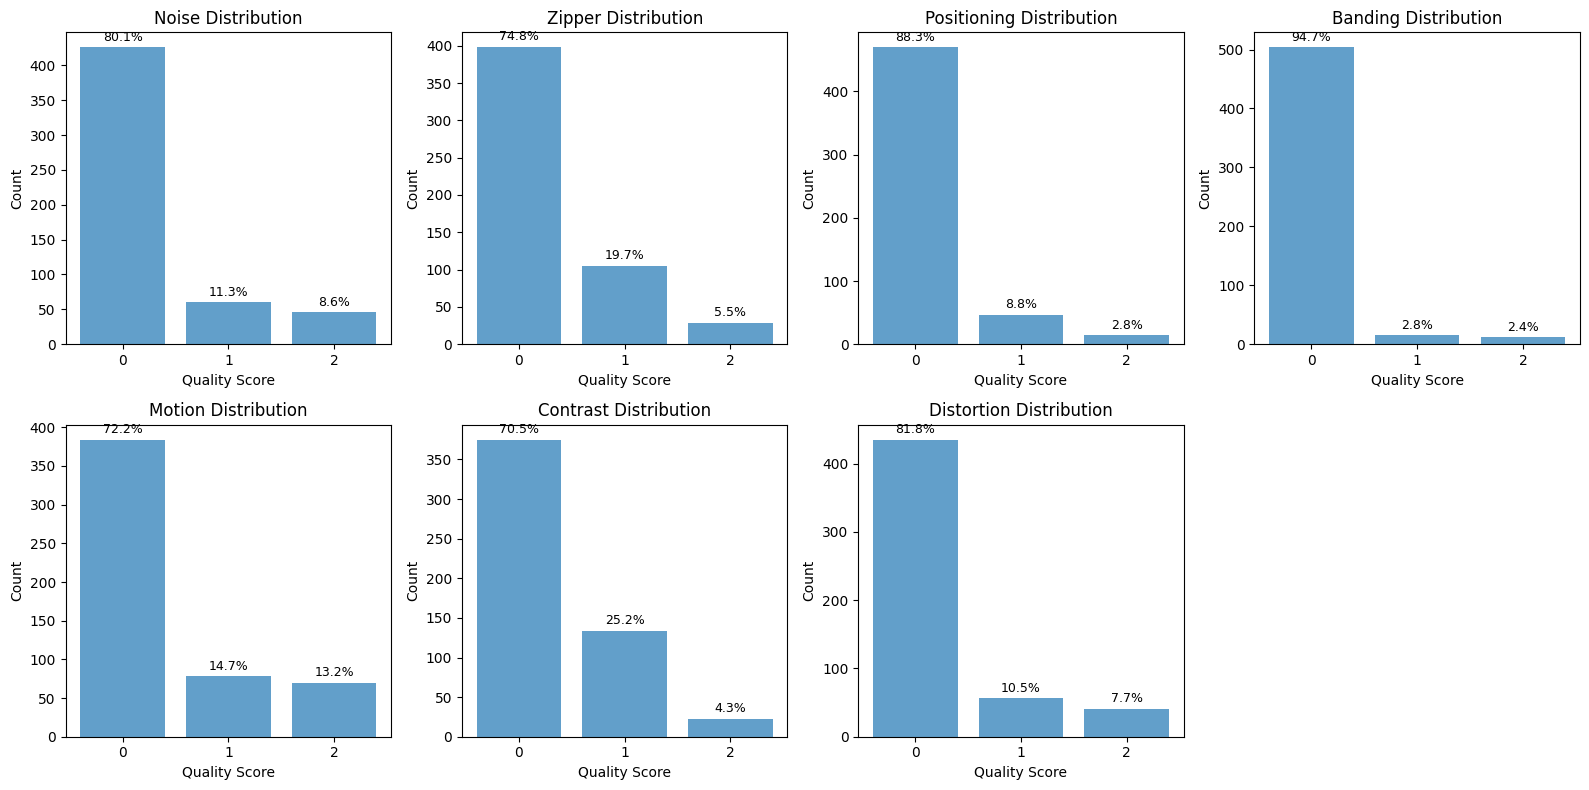

In [8]:
# Visualize quality score distributions
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, category in enumerate(artifact_categories):
    counts = df[category].value_counts().sort_index()
    axes[i].bar(counts.index, counts.values, alpha=0.7)
    axes[i].set_title(f'{category} Distribution')
    axes[i].set_xlabel('Quality Score')
    axes[i].set_ylabel('Count')
    axes[i].set_xticks([0, 1, 2])

    # Add percentage labels
    for j, count in enumerate(counts.values):
        axes[i].text(counts.index[j], count + 5, f'{count/len(df)*100:.1f}%',
                    ha='center', va='bottom', fontsize=9)

# Remove empty subplot
axes[7].remove()

plt.tight_layout()
plt.show()

### 2.2 Orientation-Specific Quality Analysis

### **MRI Orientation Primer**

**Understanding MRI Orientations:**
- **Axial (Transverse)**: Horizontal slices, like looking down at the top of the head
- **Coronal**: Vertical slices from front to back, like a face-on view
- **Sagittal**: Vertical slices from side to side, like a profile view

**Why Analyze by Orientation?**
- Different orientations may be more susceptible to specific artifacts
- Motion artifacts might affect orientations differently based on scan order
- Some anatomical structures are better visualized in certain orientations

### **What the Heatmap Reveals:**
- **Color Intensity**: Percentage of images with each quality score
- **Patterns**: Do certain orientations show more artifacts?
- **Consistency**: Are quality patterns similar across orientations?

### **Analysis Questions:**
1. **Orientation Bias**: Do you see systematic differences between orientations?
2. **Acquisition Order**: How might scan sequence affect artifact distribution?
3. **Clinical Impact**: Which orientation problems would be most concerning for diagnosis?
4. **Technical Factors**: What scanner limitations might explain orientation-specific patterns?

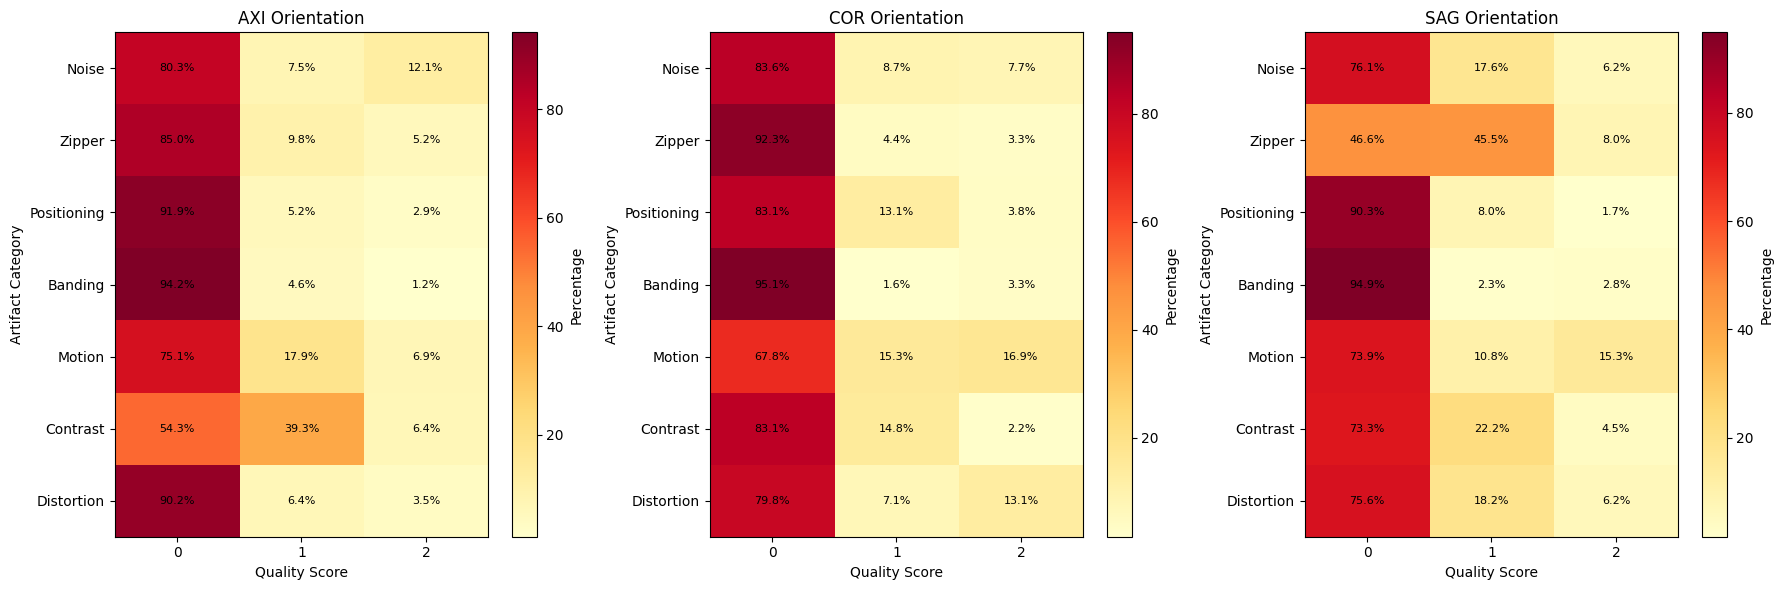

In [9]:
# Create heatmap of quality scores by orientation
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
orientations = ['axi', 'cor', 'sag']

for i, orientation in enumerate(orientations):
    subset = df[df['orientation'] == orientation]

    # Calculate mean scores for each artifact category
    mean_scores = subset[artifact_categories].mean()

    # Create heatmap data
    heatmap_data = []
    for category in artifact_categories:
        counts = subset[category].value_counts().sort_index()
        percentages = [(counts.get(j, 0)/len(subset)*100) for j in range(3)]
        heatmap_data.append(percentages)

    heatmap_data = np.array(heatmap_data)

    im = axes[i].imshow(heatmap_data, cmap='YlOrRd', aspect='auto')
    axes[i].set_title(f'{orientation.upper()} Orientation')
    axes[i].set_xlabel('Quality Score')
    axes[i].set_ylabel('Artifact Category')
    axes[i].set_xticks([0, 1, 2])
    axes[i].set_yticks(range(len(artifact_categories)))
    axes[i].set_yticklabels(artifact_categories)

    # Add percentage text
    for row in range(len(artifact_categories)):
        for col in range(3):
            text = axes[i].text(col, row, f'{heatmap_data[row, col]:.1f}%',
                               ha='center', va='center', color='black', fontsize=8)

    plt.colorbar(im, ax=axes[i], label='Percentage')

plt.tight_layout()
plt.show()

### 2.3 Sample Image Visualization

### **Visual Quality Assessment**

**Why Visualize Sample Images?**
- **Ground Truth Validation**: Verify that quality scores match visual assessment
- **Artifact Recognition**: Learn to identify different artifact types
- **Data Quality**: Check for obvious data loading or preprocessing errors
- **Clinical Context**: Understand what radiologists see in practice

**What to Look For:**
- **Noise**: Grainy, speckled appearance reducing image clarity
- **Motion**: Blurring or ghosting artifacts from patient movement
- **Contrast**: Poor differentiation between tissue types
- **Distortion**: Geometric warping of anatomical structures
- **Positioning**: Off-center or tilted anatomy

### **Image Analysis Strategy:**
1. **Compare Orientations**: How do artifacts manifest differently across views?
2. **Severity Assessment**: Do the numerical scores match visual impression?
3. **Anatomical Consistency**: Can you identify key brain structures?
4. **Technical Quality**: Are the preprocessing steps working correctly?

### **Learning Opportunity:**
Try to predict quality scores before looking at the labels. This helps develop the visual pattern recognition that your AI model will need to learn!

Patients with all 3 orientations: 144
Patients with partial orientations: 100
First few patients with all orientations: ['LISA_0001', 'LISA_0002', 'LISA_0003', 'LISA_0004', 'LISA_0005']
Patient: LISA_0001
Available orientations for LISA_0001: ['axi', 'cor', 'sag']


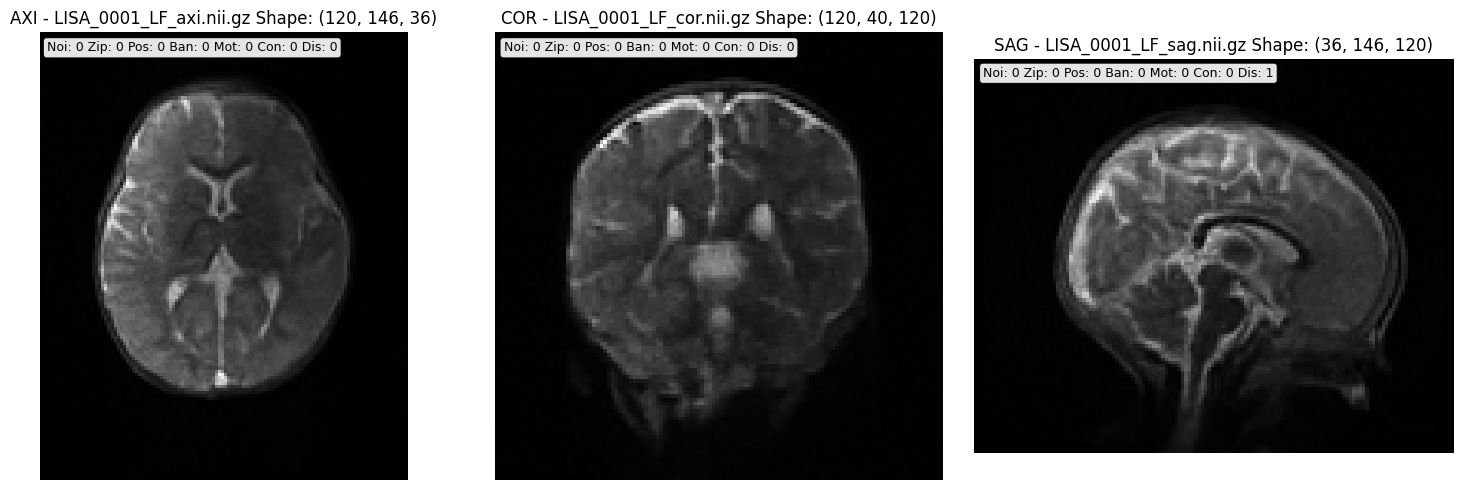

Patient: LISA_0002
Available orientations for LISA_0002: ['axi', 'cor', 'sag']


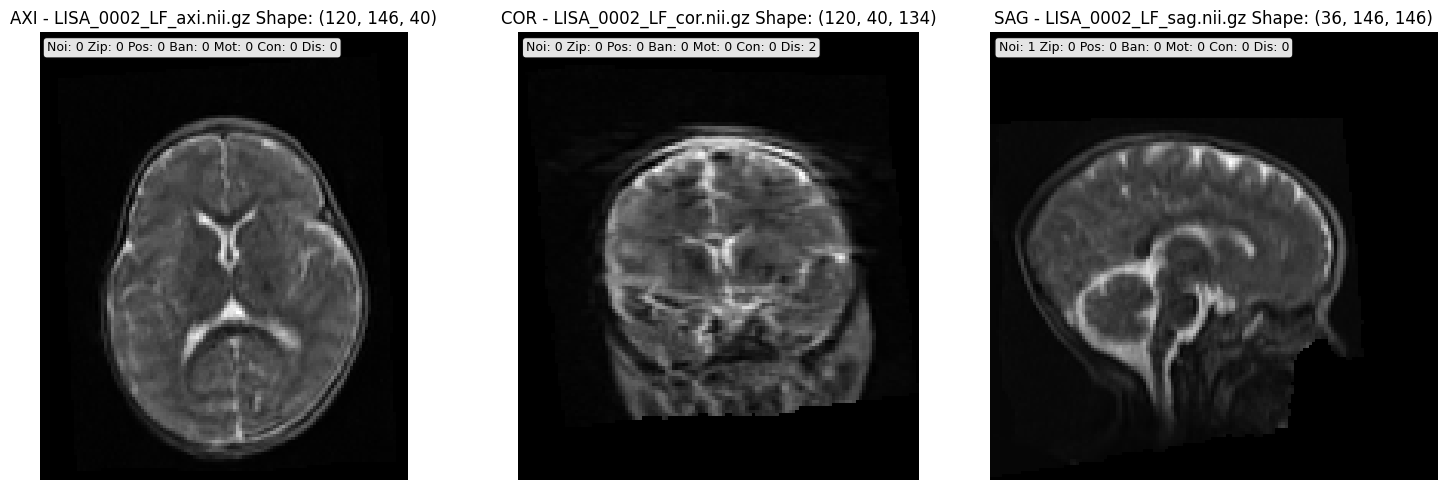

Patient: LISA_0003
Available orientations for LISA_0003: ['axi', 'cor', 'sag']


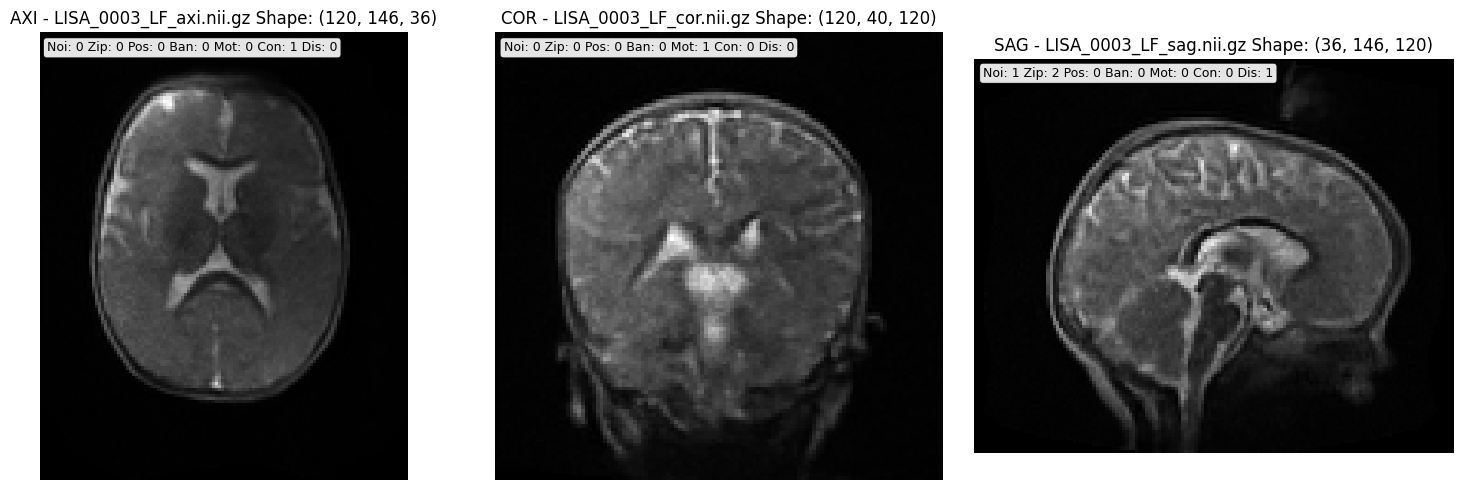

In [10]:
def load_and_visualize_sample(patient_id, slice_idx=None):
    """Load and visualize a sample patient's available orientations"""

    # First, check what orientations are available for this patient
    patient_files = df[df['patient_id'] == patient_id]

    if patient_files.empty:
        print(f"No files found for patient {patient_id}")
        return

    available_orientations = patient_files['orientation'].unique()
    print(f"Available orientations for {patient_id}: {list(available_orientations)}")

    # Create subplot based on available orientations
    num_orientations = len(available_orientations)
    fig, axes = plt.subplots(1, num_orientations, figsize=(5*num_orientations, 5))

    # Handle case where there's only one orientation
    if num_orientations == 1:
        axes = [axes]

    for i, orient in enumerate(available_orientations):
        filename = f'{patient_id}_LF_{orient}.nii.gz'
        filepath = data_dir / filename

        if filepath.exists():
            try:
                # Load image
                img = nib.load(filepath)
                data = img.get_fdata()

                # Get middle slice if not specified
                if slice_idx is None:
                    slice_idx = data.shape[2] // 2

                # Display slice (handle different orientations properly)
                if orient == 'axi':
                    slice_data = data[:, :, slice_idx]
                elif orient == 'cor':
                    slice_data = data[:, slice_idx, :]
                elif orient == 'sag':
                    slice_data = data[slice_idx, :, :]
                else:
                    slice_data = data[:, :, slice_idx]  # default

                #rotate the image by 90 degrees
                slice_data = np.rot90(slice_data, k=1)

                axes[i].imshow(slice_data, cmap='gray')
                axes[i].set_title(f'{orient.upper()} - {filename} Shape: {data.shape}')
                axes[i].axis('off')

                # Get quality scores for this image
                img_row = df[df['filename'] == filename]
                if not img_row.empty:
                    scores = img_row[artifact_categories].iloc[0]
                    # Format scores more compactly
                    score_pairs = [f'{cat[:3]}: {score}' for cat, score in scores.items()]
                    score_text = ' '.join(score_pairs)
                    axes[i].text(0.02, 0.98, score_text, transform=axes[i].transAxes,
                               fontsize=9, verticalalignment='top',
                               bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

            except Exception as e:
                axes[i].text(0.5, 0.5, f'Error loading {filename}: {str(e)}',
                            transform=axes[i].transAxes, ha='center', va='center')
                axes[i].set_title(f'{orient.upper()} - ERROR')
        else:
            axes[i].text(0.5, 0.5, f'File not found: {filename}',
                        transform=axes[i].transAxes, ha='center', va='center')
            axes[i].set_title(f'{orient.upper()} - NOT FOUND')

    plt.tight_layout()
    plt.show()

def find_patients_with_all_orientations():
    """Find patients that have all three orientations available"""
    patients_with_all = []
    patients_with_some = []

    for patient_id in df['patient_id'].unique():
        patient_files = df[df['patient_id'] == patient_id]
        orientations = set(patient_files['orientation'].unique())

        if len(orientations) == 3:  # Has all three orientations
            patients_with_all.append(patient_id)
        else:
            patients_with_some.append((patient_id, list(orientations)))

    return patients_with_all, patients_with_some

# Find better sample patients
patients_with_all, patients_with_some = find_patients_with_all_orientations()

print(f"Patients with all 3 orientations: {len(patients_with_all)}")
print(f"Patients with partial orientations: {len(patients_with_some)}")

if patients_with_all:
    print(f"First few patients with all orientations: {patients_with_all[:5]}")
    sample_patients = patients_with_all[:3]  # Take first 3 with all orientations
else:
    print("No patients have all 3 orientations. Using patients with available orientations:")
    sample_patients = ['LISA_0001', 'LISA_1001', 'LISA_2001']

# Visualize sample patients
for patient in sample_patients:
    print(f"{'='*60}")
    print(f"Patient: {patient}")
    print('='*60)
    load_and_visualize_sample(patient)

## 3. Data Preprocessing and Loading

### **Medical Image Preprocessing Fundamentals**

**Why Medical Image Preprocessing is Special:**
- **Orientation Standardization**: Ensure consistent anatomical orientation (RAS: Right-Anterior-Superior)
- **Spacing Normalization**: Account for different voxel sizes across scanners
- **Intensity Normalization**: Handle varying intensity ranges between acquisitions
- **Format Standardization**: Convert to tensors for deep learning

**Key Challenges:**
- **3D Nature**: Medical images are volumetric, not 2D
- **Physical Units**: Voxel spacing has real-world meaning (millimeters)
- **Orientation Matters**: Left/right, anterior/posterior must be preserved
- **Multi-site Data**: Different scanners may have different characteristics

### **Our Preprocessing Pipeline:**
1. **Load NIfTI files** with proper medical image handling
2. **Standardize orientation** to RAS coordinate system
3. **Resample spacing** to consistent voxel sizes
4. **Normalize intensities** to [0,1] range
5. **Resize volumes** to manageable dimensions for GPU memory
6. **Convert to tensors** for PyTorch compatibility

In [11]:
def prepare_data_list(df, data_dir):
    """Prepare data list for MONAI DataLoader"""

    data_list = []

    for idx, row in df.iterrows():
        filename = row['filename']
        filepath = data_dir / filename

        if filepath.exists():
            # Extract orientation and encode as label
            orientation = row['orientation']
            orientation_mapping = {'axi': 0, 'cor': 1, 'sag': 2}

            # Get quality scores
            quality_scores = row[artifact_categories].values.astype(np.float32)

            data_item = {
                'image': str(filepath),
                'patient_id': row['patient_id'],
                'orientation': orientation_mapping[orientation],
                'filename': filename,
                'quality_scores': quality_scores,
                # Individual artifact scores
                'noise': row['Noise'],
                'zipper': row['Zipper'],
                'positioning': row['Positioning'],
                'banding': row['Banding'],
                'motion': row['Motion'],
                'contrast': row['Contrast'],
                'distortion': row['Distortion']
            }

            data_list.append(data_item)

    return data_list

# Prepare data list
data_list = prepare_data_list(df, data_dir)
print(f"Total samples prepared: {len(data_list)}")
print(f"Sample data item keys: {list(data_list[0].keys())}")

Total samples prepared: 532
Sample data item keys: ['image', 'patient_id', 'orientation', 'filename', 'quality_scores', 'noise', 'zipper', 'positioning', 'banding', 'motion', 'contrast', 'distortion']


### 3.1 Patient-Level Data Splitting Strategy

### **Critical Concept: Preventing Data Leakage**

**The Problem:**
If we randomly split images without considering patients, we might have:
- Patient A's axial scan in training set
- Patient A's coronal scan in test set
- This leads to **overoptimistic performance estimates**!

**Our Solution: Patient-Level Splitting**
- Split by **patient ID**, not by individual images
- Ensures no patient appears in both training and test sets
- Provides realistic performance estimates for new patients

**Split Strategy:**
- **70% Training**: For model learning and parameter updates
- **15% Validation**: For hyperparameter tuning and early stopping
- **15% Testing**: For final, unbiased performance evaluation

### **Why This Matters:**
1. **Clinical Validity**: Real deployment means scanning new patients, not new images of known patients
2. **Generalization**: Ensures model works across different individuals
3. **Ethical AI**: Prevents inflated performance claims that could mislead clinicians

### **Think About It:**
How would the results differ if we used image-level vs. patient-level splitting? Why might this difference be crucial for clinical adoption?

In [12]:
# Split data by patient to avoid data leakage
# (images from same patient should not be in both train and test sets)

# Get unique patient IDs
unique_patients = df['patient_id'].unique()
print(f"Total unique patients: {len(unique_patients)}")

# Split patients into train/val/test
train_patients, temp_patients = train_test_split(
    unique_patients, test_size=0.3, random_state=42
)
val_patients, test_patients = train_test_split(
    temp_patients, test_size=0.5, random_state=42
)

print(f"Train patients: {len(train_patients)}")
print(f"Validation patients: {len(val_patients)}")
print(f"Test patients: {len(test_patients)}")

# Create data splits
train_data = [item for item in data_list if item['patient_id'] in train_patients]
val_data = [item for item in data_list if item['patient_id'] in val_patients]
test_data = [item for item in data_list if item['patient_id'] in test_patients]

print(f"Train images: {len(train_data)}")
print(f"Validation images: {len(val_data)}")
print(f"Test images: {len(test_data)}")

Total unique patients: 244
Train patients: 170
Validation patients: 37
Test patients: 37
Train images: 374
Validation images: 77
Test images: 81


### 3.2 Medical Image Transforms and Augmentation

### **Understanding Each Transform**

**Core Preprocessing Transforms:**
1. **`LoadImaged`**: Reads NIfTI files while preserving medical metadata
2. **`EnsureChannelFirstd`**: Adds channel dimension for CNN compatibility
3. **`Orientationd`**: Standardizes to RAS (Right-Anterior-Superior) orientation
4. **`Spacingd`**: Resamples to consistent voxel spacing (1.5×1.5×3.0 mm)
5. **`ScaleIntensityRanged`**: Normalizes intensities to [0,1] range
6. **`Resized`**: Resizes to (128×128×64) for computational efficiency
7. **`ToTensord`**: Converts to PyTorch tensors

### **Augmentation Strategy for Medical Images**

**Why Augment Medical Images?**
- **Limited Data**: Medical datasets are often smaller than natural image datasets
- **Generalization**: Helps model handle variations in patient positioning, scanner settings
- **Robustness**: Improves performance on slightly different acquisition conditions

**Our Augmentation Pipeline:**
- **Rotation**: ±15° rotations simulate patient positioning variations
- **Flipping**: Horizontal/vertical flips (careful with anatomical consistency!)
- **Zoom**: 90-110% scaling simulates different field-of-view settings
- **Noise**: Gaussian noise simulates scanner noise variations
- **Contrast**: Gamma adjustments simulate different scanner calibrations

### **Medical Image Augmentation Considerations:**
1. **Anatomical Validity**: Ensure augmentations don't create impossible anatomy
2. **Clinical Realism**: Augmentations should reflect real acquisition variations
3. **Label Consistency**: Some augmentations might change artifact visibility
4. **Orientation Preservation**: Be careful with left-right orientation

### **Discussion Points:**
- Which augmentations are most/least appropriate for medical images?
- How might augmentation affect different artifact types?
- What are the risks of over-augmentation in medical AI?

In [13]:
# Define image processing transforms
img_size = (128, 128, 32)  # Resize to manageable size

# Base transforms (applied to all data)
base_transforms = Compose([
    LoadImaged(keys=["image"]),
    EnsureChannelFirstd(keys=["image"]),
    Orientationd(keys=["image"], axcodes="RAS"),
    Spacingd(keys=["image"], pixdim=(1.5, 1.5, 1.5), mode="bilinear"),
    ScaleIntensityRanged(keys=["image"], a_min=0, a_max=1000, b_min=0.0, b_max=1.0, clip=True),
    Resized(keys=["image"], spatial_size=img_size, mode="trilinear"),
    ToTensord(keys=["image"])
])

# Training transforms (includes augmentation)
train_transforms = Compose([
    LoadImaged(keys=["image"]),
    EnsureChannelFirstd(keys=["image"]),
    Orientationd(keys=["image"], axcodes="RAS"),
    Spacingd(keys=["image"], pixdim=(1.5, 1.5, 1.5), mode="bilinear"),
    ScaleIntensityRanged(keys=["image"], a_min=0, a_max=1000, b_min=0.0, b_max=1.0, clip=True),
    Resized(keys=["image"], spatial_size=img_size, mode="trilinear"),
    # Augmentations - using standard MONAI transforms
    RandRotated(keys=["image"], range_x=np.pi/12, range_y=np.pi/12, range_z=np.pi/12, prob=0.3),
    RandFlipd(keys=["image"], prob=0.3, spatial_axis=0),
    RandFlipd(keys=["image"], prob=0.3, spatial_axis=1),
    RandZoomd(keys=["image"], min_zoom=0.9, max_zoom=1.1, prob=0.3),
    RandGaussianNoised(keys=["image"], std=0.01, prob=0.3),
    RandAdjustContrastd(keys=["image"], gamma=(0.8, 1.2), prob=0.3),
    ToTensord(keys=["image"])
])

# Validation/test transforms (no augmentation)
val_transforms = base_transforms

In [14]:
class RandRotateByAxisd(Transform):
    def __init__(self, keys, degrees=15, prob=0.5, keep_size=True):
        self.keys = keys
        self.degrees = degrees
        self.prob = prob
        self.keep_size = keep_size

    def __call__(self, data):
        if self.degrees == 0:
            return data

        # Check if orientation information is available
        orientation_key = None
        if "orientation" in data:
            orientation_key = "orientation"
        elif "label" in data:
            orientation_key = "label"
        else:
            # If no orientation info, apply random rotation
            range_x = np.deg2rad(self.degrees) * np.random.uniform(-1, 1)
            range_y = np.deg2rad(self.degrees) * np.random.uniform(-1, 1)
            range_z = np.deg2rad(self.degrees) * np.random.uniform(-1, 1)
            rotation_transform = RandRotated(
                keys=self.keys,
                range_x=range_x,
                range_y=range_y,
                range_z=range_z,
                prob=self.prob,
                keep_size=self.keep_size,
            )
            return rotation_transform(data)

        orientation_value = data[orientation_key]

        # 2 == sag == x
        if (
            isinstance(orientation_value, np.ndarray)
            and orientation_value[-1] == 2
            or isinstance(orientation_value, (np.int64, int))
            and orientation_value == 2
        ):
            range_x = np.deg2rad(self.degrees)
            range_y = 0
            range_z = 0
        # 1 == cor == y
        elif (
            isinstance(orientation_value, np.ndarray)
            and orientation_value[-1] == 1
            or isinstance(orientation_value, (np.int64, int))
            and orientation_value == 1
        ):
            range_x = 0
            range_y = np.deg2rad(self.degrees)
            range_z = 0
        # 0 == axi == z
        elif (
            isinstance(orientation_value, np.ndarray)
            and orientation_value[-1] == 0
            or isinstance(orientation_value, (np.int64, int))
            and orientation_value == 0
        ):
            range_x = 0
            range_y = 0
            range_z = np.deg2rad(self.degrees)
        else:
            # Fallback to random rotation if orientation value is unexpected
            range_x = np.deg2rad(self.degrees) * np.random.uniform(-1, 1)
            range_y = np.deg2rad(self.degrees) * np.random.uniform(-1, 1)
            range_z = np.deg2rad(self.degrees) * np.random.uniform(-1, 1)

        rotation_transform = RandRotated(
            keys=self.keys,
            range_x=range_x,
            range_y=range_y,
            range_z=range_z,
            prob=self.prob,
            keep_size=self.keep_size,
        )
        return rotation_transform(data)

In [15]:
# Define image processing transforms
img_size = (128, 128, 32)  # Resize to manageable size

# Base transforms (applied to all data)
base_transforms = Compose([
    LoadImaged(keys=["image"]),
    EnsureChannelFirstd(keys=["image"]),
    Orientationd(keys=["image"], axcodes="RAS"),
    Spacingd(keys=["image"], pixdim=(1.5, 1.5, 1.5), mode="bilinear"),
    ScaleIntensityRanged(keys=["image"], a_min=0, a_max=1000, b_min=0.0, b_max=1.0, clip=True),
    Resized(keys=["image"], spatial_size=img_size, mode="trilinear"),
    ToTensord(keys=["image"])
])

# Training transforms (includes augmentation)
train_transforms = Compose([
    LoadImaged(keys=["image"]),
    EnsureChannelFirstd(keys=["image"]),
    Orientationd(keys=["image"], axcodes="RAS"),
    Spacingd(keys=["image"], pixdim=(1.5, 1.5, 1.5), mode="bilinear"),
    ScaleIntensityRanged(keys=["image"], a_min=0, a_max=1000, b_min=0.0, b_max=1.0, clip=True),
    Resized(keys=["image"], spatial_size=img_size, mode="trilinear"),
    # Augmentations
    RandRotateByAxisd(keys=["image"], degrees=10, prob=0.3),
    RandFlipd(keys=["image"], prob=0.3, spatial_axis=0),
    RandFlipd(keys=["image"], prob=0.3, spatial_axis=1),
    RandZoomd(keys=["image"], min_zoom=0.9, max_zoom=1.1, prob=0.3),
    RandGaussianNoised(keys=["image"], std=0.01, prob=0.3),
    RandAdjustContrastd(keys=["image"], gamma=(0.8, 1.2), prob=0.3),
    ToTensord(keys=["image"])
])

# Validation/test transforms (no augmentation)
val_transforms = base_transforms

### 3.4 Data Loading

- **Image Shape**: Should be (batch_size, 1, 128, 128, 32)
- **Quality Scores Shape**: Should be (batch_size, 7) for 7 artifact categories
- **Data Types**: Proper tensor types for training
- **Visual Quality**: Anatomical structures should be recognizable

In [16]:
# Create datasets
train_dataset = Dataset(data=train_data, transform=train_transforms)
val_dataset = Dataset(data=val_data, transform=val_transforms)
test_dataset = Dataset(data=test_data, transform=val_transforms)

# Create data loaders
batch_size = 32
num_workers = 0

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 12
Validation batches: 3
Test batches: 3


In [17]:
#verify the a batch of data - check the shape of the image, quality scores, orientation
batch = next(iter(train_loader))

print(batch['image'].shape)
print(batch['quality_scores'].shape)
print(batch['orientation'].shape)

torch.Size([32, 1, 128, 128, 32])
torch.Size([32, 7])
torch.Size([32])


## 4. Advanced Model Architecture with MONAI DenseNet

### **Why Use MONAI's Pre-trained Networks?**

**Advantages of MONAI DenseNet:**
- **Medical Image Optimized**: Specifically designed for 3D medical imaging
- **Dense Connections**: Feature reuse through dense blocks improves gradient flow
- **Proven Architecture**: DenseNet has shown excellent performance on medical tasks
- **Transfer Learning**: Can leverage pre-trained weights from medical imaging tasks
- **Memory Efficient**: Dense connections reduce parameter count while maintaining capacity

### **DenseNet Architecture Primer**

**Dense Blocks Concept:**
- Each layer receives input from ALL previous layers
- Promotes feature reuse and reduces vanishing gradient problem
- Creates implicit ensemble of exponentially many paths through network
- Particularly effective for medical images with subtle feature differences

**Our Custom Implementation:**
```python
class AxisDenseNet264(nn.Module):
    def __init__(self, spatial_dims, in_channels, out_channels):
        # DenseNet264 backbone for feature extraction
        # Custom classification heads for multi-task learning
        # Separate outputs for quality scores and orientation
```

### **Multi-Task Learning Strategy**

**Why Multi-Task Learning?**
- **Quality Assessment**: Primary task - predict artifact severity scores
- **Orientation Detection**: Auxiliary task - helps model understand spatial structure
- **Shared Representations**: Common features benefit both tasks
- **Regularization Effect**: Multi-task learning often improves generalization

**Architecture Components:**
1. **Shared Backbone**: DenseNet264 feature extractor (2688 features)
2. **Quality Head**: Linear layer for artifact score prediction (7 outputs × 3 classes)
3. **Orientation Head**: Linear layer for orientation classification (3 classes)

###**Technical Implementation Details**

**Feature Extraction:**
- **DenseNet264**: 264-layer dense network with growth rate optimization
- **3D Convolutions**: Handle volumetric nature of MRI data
- **Adaptive Pooling**: Reduces spatial dimensions to single feature vector
- **Feature Dimension**: 2688-dimensional representation

**Classification Heads:**
- **Quality Scores**: 21 outputs (7 artifacts × 3 severity levels)
- **Orientation**: 3 outputs (axial, coronal, sagittal)
- **Separate Losses**: Independent optimization for each task

### **Architecture Design Questions:**
1. **Multi-Task vs Single-Task**: How does orientation prediction help quality assessment?
2. **Feature Sharing**: Should we share all features or have task-specific layers?
3. **Loss Weighting**: How should we balance the two tasks during training?
4. **Transfer Learning**: Should we use pre-trained weights or train from scratch?

In [18]:
class AxisDenseNet264(nn.Module):
    """
    Multi-task DenseNet for MRI quality assessment and orientation prediction.

    This architecture combines:
    1. Quality assessment (primary task): Predicts artifact severity for 7 categories
    2. Orientation prediction (auxiliary task): Predicts scan orientation (axi/cor/sag)

    The multi-task approach helps the model learn better spatial representations
    by understanding both image content (quality) and spatial structure (orientation).
    """
    def __init__(self, spatial_dims=3, in_channels=1, out_channels=21):
        super(AxisDenseNet264, self).__init__()

        # Initialize MONAI's DenseNet264 as backbone
        self.base_model = nets.DenseNet264(
            spatial_dims=spatial_dims,    # 3D convolutions for volumetric data
            in_channels=in_channels,      # Single-channel MRI
            out_channels=out_channels,    # Will be modified below
        )

        # Replace the default classification layers with our custom pooling
        # This gives us access to the 2688-dimensional feature representation
        self.base_model.class_layers = nn.Sequential(
            nn.ReLU(inplace=True),                    # Non-linearity
            nn.AdaptiveAvgPool3d(output_size=1),      # Global average pooling
            nn.Flatten(start_dim=1, end_dim=-1),      # Flatten to vector
        )

        # Multi-label classification head for quality scores
        # 7 artifacts × 3 severity levels = 21 total classes
        # But we'll treat this as 7 separate 3-class problems
        self.artifact_heads = nn.ModuleList([
            nn.Linear(in_features=2688, out_features=3, bias=True)
            for _ in range(7)  # One head per artifact type
        ])

        # Auxiliary task: orientation classification
        # Helps model understand spatial structure
        self.orientation_head = nn.Linear(
            in_features=2688,
            out_features=3,   # axial, coronal, sagittal
            bias=True
        )

    def forward(self, x):
        """
        Forward pass through the network.

        Returns:
            artifact_scores: List of 7 tensors, each (batch_size, 3) for artifact severity
            orientation_pred: Tensor (batch_size, 3) for orientation classification
        """
        # Extract features using DenseNet backbone
        features = self.base_model.features(x)      # Feature extraction
        features = self.base_model.class_layers(features)  # Pool and flatten

        # Multi-label artifact prediction (7 separate classifications)
        artifact_outputs = []
        for head in self.artifact_heads:
            artifact_outputs.append(head(features))

        # Orientation prediction (auxiliary task)
        orientation_output = self.orientation_head(features)

        return artifact_outputs, orientation_output

# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AxisDenseNet264(
    spatial_dims=3,
    in_channels=1,
    out_channels=21  # This parameter is not used due to our custom heads
).to(device)

print(f"Model device: {device}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Test model with sample input
sample_input = torch.randn(2, 1, 128, 128, 64).to(device)
artifact_outputs, orientation_output = model(sample_input)

print(f"Model Output Verification:")
print(f"Number of artifact heads: {len(artifact_outputs)}")
print(f"Each artifact head shape: {artifact_outputs[0].shape}")
print(f"Orientation output shape: {orientation_output.shape}")

# Verify the architecture makes sense
expected_artifact_shape = (2, 3)  # batch_size=2, 3 severity levels
expected_orientation_shape = (2, 3)  # batch_size=2, 3 orientations

assert all(output.shape == expected_artifact_shape for output in artifact_outputs), \
    "Artifact output shapes don't match expected dimensions"
assert orientation_output.shape == expected_orientation_shape, \
    "Orientation output shape doesn't match expected dimensions"

Model device: cuda
Total parameters: 40,310,424
Trainable parameters: 40,310,424
Model Output Verification:
Number of artifact heads: 7
Each artifact head shape: torch.Size([2, 3])
Orientation output shape: torch.Size([2, 3])


## 5. Multi-Task Training Pipeline Setup

### **Multi-Task Learning Strategy**

**Why Multi-Task Learning for Medical Images?**
- **Primary Task**: Quality assessment - predict artifact severity scores
- **Auxiliary Task**: Orientation prediction - helps model understand spatial structure
- **Shared Representations**: Common backbone learns features useful for both tasks
- **Regularization**: Auxiliary task prevents overfitting to quality assessment alone
- **Clinical Relevance**: Orientation awareness improves spatial understanding

### **Training Configuration for Multi-Task Learning**

**Loss Function Strategy:**
- **Artifact Loss**: Sum of CrossEntropyLoss for each of the 7 artifact types
- **Orientation Loss**: Single CrossEntropyLoss for 3-class orientation prediction
- **Combined Loss**: Weighted sum of both losses with adjustable balance

**Loss Weighting Philosophy:**
- **Primary Task Weight**: 1.0 (quality assessment is our main objective)
- **Auxiliary Task Weight**: 0.3 (orientation helps but shouldn't dominate)
- **Adaptive Weighting**: Could be adjusted based on validation performance

**Optimizer Configuration:**
- **Adam Optimizer**: Reliable for multi-task learning
- **Learning Rate**: 0.0001 (more conservative for complex model)
- **Weight Decay**: 1e-4 for regularization
- **Scheduler**: ReduceLROnPlateau for adaptive learning rate reduction

In [19]:
# Multi-task training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)

# Training configuration
num_epochs = 25
artifact_names = ['Noise', 'Zipper', 'Positioning', 'Banding', 'Motion', 'Contrast', 'Distortion']

# Loss weighting for multi-task learning
artifact_weight = 1.0      # Primary task
orientation_weight = 0.3   # Auxiliary task

# Tracking variables
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_artifact_accuracies = []
train_orientation_accuracies = []
val_artifact_accuracies = []
val_orientation_accuracies = []

def calculate_multi_task_accuracy(artifact_outputs, orientation_output,
                                artifact_targets, orientation_targets):
    """
    Calculate accuracy for both tasks in multi-task learning.

    Returns:
        artifact_accuracy: Accuracy across all artifact predictions
        orientation_accuracy: Accuracy for orientation prediction
        combined_accuracy: Weighted combination of both accuracies
    """
    # Artifact accuracy (average across all 7 artifact types)
    artifact_correct = 0
    artifact_total = 0

    for i, output in enumerate(artifact_outputs):
        _, predicted = torch.max(output.data, 1)
        target = artifact_targets[:, i].long()
        artifact_total += target.size(0)
        artifact_correct += (predicted == target).sum().item()

    artifact_accuracy = artifact_correct / artifact_total

    # Orientation accuracy
    _, orientation_predicted = torch.max(orientation_output.data, 1)
    orientation_target = orientation_targets.long()
    orientation_correct = (orientation_predicted == orientation_target).sum().item()
    orientation_accuracy = orientation_correct / orientation_target.size(0)

    # Combined accuracy (weighted by task importance)
    combined_accuracy = (artifact_weight * artifact_accuracy +
                        orientation_weight * orientation_accuracy) / (artifact_weight + orientation_weight)

    return artifact_accuracy, orientation_accuracy, combined_accuracy

def train_epoch_multitask(model, train_loader, criterion, optimizer, device):
    """
    Train for one epoch with multi-task learning.
    """
    model.train()
    total_loss = 0
    total_artifact_accuracy = 0
    total_orientation_accuracy = 0
    total_combined_accuracy = 0

    for batch_idx, batch in enumerate(train_loader):
        images = batch['image'].to(device)
        artifact_targets = batch['quality_scores'].to(device)
        orientation_targets = batch['orientation'].to(device)

        optimizer.zero_grad()

        # Forward pass
        artifact_outputs, orientation_output = model(images)

        # Calculate losses
        artifact_loss = 0
        for i, output in enumerate(artifact_outputs):
            target = artifact_targets[:, i].long()
            artifact_loss += criterion(output, target)

        orientation_loss = criterion(orientation_output, orientation_targets.long())

        # Combined loss with weighting
        total_loss_batch = (artifact_weight * artifact_loss +
                           orientation_weight * orientation_loss)

        # Backward pass
        total_loss_batch.backward()
        optimizer.step()

        # Calculate accuracies
        artifact_acc, orientation_acc, combined_acc = calculate_multi_task_accuracy(
            artifact_outputs, orientation_output, artifact_targets, orientation_targets
        )

        total_loss += total_loss_batch.item()
        total_artifact_accuracy += artifact_acc
        total_orientation_accuracy += orientation_acc
        total_combined_accuracy += combined_acc

        if batch_idx % 5 == 0:
            print(f'Batch {batch_idx}/{len(train_loader)}, '
                  f'Loss: {total_loss_batch.item():.4f}, '
                  f'Artifact Acc: {artifact_acc:.3f}, '
                  f'Orient Acc: {orientation_acc:.3f}')

    return (total_loss / len(train_loader),
            total_artifact_accuracy / len(train_loader),
            total_orientation_accuracy / len(train_loader),
            total_combined_accuracy / len(train_loader))

def validate_epoch_multitask(model, val_loader, criterion, device):
    """
    Validate for one epoch with multi-task learning.
    """
    model.eval()
    total_loss = 0
    total_artifact_accuracy = 0
    total_orientation_accuracy = 0
    total_combined_accuracy = 0

    with torch.no_grad():
        for batch in val_loader:
            images = batch['image'].to(device)
            artifact_targets = batch['quality_scores'].to(device)
            orientation_targets = batch['orientation'].to(device)

            # Forward pass
            artifact_outputs, orientation_output = model(images)

            # Calculate losses
            artifact_loss = 0
            for i, output in enumerate(artifact_outputs):
                target = artifact_targets[:, i].long()
                artifact_loss += criterion(output, target)

            orientation_loss = criterion(orientation_output, orientation_targets.long())

            # Combined loss
            total_loss_batch = (artifact_weight * artifact_loss +
                               orientation_weight * orientation_loss)

            # Calculate accuracies
            artifact_acc, orientation_acc, combined_acc = calculate_multi_task_accuracy(
                artifact_outputs, orientation_output, artifact_targets, orientation_targets
            )

            total_loss += total_loss_batch.item()
            total_artifact_accuracy += artifact_acc
            total_orientation_accuracy += orientation_acc
            total_combined_accuracy += combined_acc

    return (total_loss / len(val_loader),
            total_artifact_accuracy / len(val_loader),
            total_orientation_accuracy / len(val_loader),
            total_combined_accuracy / len(val_loader))

print("Multi-task training setup complete!")
print(f"Artifact task weight: {artifact_weight}")
print(f"Orientation task weight: {orientation_weight}")
print(f"Total trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Multi-task training setup complete!
Artifact task weight: 1.0
Orientation task weight: 0.3
Total trainable parameters: 40,310,424


## 6. Multi-Task Training Loop

**What Makes This Training Special:**
- **Multi-Task Learning**: Simultaneously learns quality assessment and orientation prediction
- **Adaptive Learning Rate**: ReduceLROnPlateau automatically adjusts learning rate
- **Comprehensive Monitoring**: Tracks both primary and auxiliary task performance
- **Early Stopping**: Prevents overfitting based on combined accuracy

**Training Philosophy:**
- **Quality Assessment (Primary)**: The main clinical objective
- **Orientation Prediction (Auxiliary)**: Helps model understand spatial structure
- **Balanced Learning**: Weighted loss ensures primary task dominance while benefiting from auxiliary task

### **What We Monitor:**
1. **Combined Loss**: Weighted sum of both task losses
2. **Artifact Accuracy**: Performance on quality assessment (primary goal)
3. **Orientation Accuracy**: Performance on spatial understanding (auxiliary goal)
4. **Learning Rate**: Automatic adjustments based on plateau detection

### **Success Metrics:**
- **Clinical Goal**: High artifact detection accuracy for patient safety
- **Technical Goal**: Balanced performance across both tasks
- **Generalization Goal**: Good performance on validation set (unseen patients)

In [20]:
# Multi-task training loop with comprehensive monitoring
best_combined_accuracy = 0
best_artifact_accuracy = 0
patience = 5
patience_counter = 0

print("Starting Multi-Task Training...")
print("=" * 60)
print(f"Architecture: MONAI DenseNet264 with {sum(p.numel() for p in model.parameters()):,} parameters")
print(f"Primary Task: Quality Assessment (7 artifacts × 3 severity levels)")
print(f"Auxiliary Task: Orientation Prediction (3 orientations)")
print(f"Loss Weighting: Artifact={artifact_weight}, Orientation={orientation_weight}")
print("=" * 60)

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print("-" * 50)

    # Training phase
    train_loss, train_artifact_acc, train_orientation_acc, train_combined_acc = train_epoch_multitask(
        model, train_loader, criterion, optimizer, device
    )

    # Validation phase
    val_loss, val_artifact_acc, val_orientation_acc, val_combined_acc = validate_epoch_multitask(
        model, val_loader, criterion, device
    )

    # Update learning rate based on combined accuracy
    scheduler.step(val_combined_acc)
    current_lr = optimizer.param_groups[0]['lr']

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_artifact_accuracies.append(train_artifact_acc)
    train_orientation_accuracies.append(train_orientation_acc)
    val_artifact_accuracies.append(val_artifact_acc)
    val_orientation_accuracies.append(val_orientation_acc)
    train_accuracies.append(train_combined_acc)
    val_accuracies.append(val_combined_acc)

    # Print epoch summary
    print(f" Training   - Loss: {train_loss:.4f}, "
          f"Artifact: {train_artifact_acc:.3f}, "
          f"Orient: {train_orientation_acc:.3f}, "
          f"Combined: {train_combined_acc:.3f}")
    print(f" Validation - Loss: {val_loss:.4f}, "
          f"Artifact: {val_artifact_acc:.3f}, "
          f"Orient: {val_orientation_acc:.3f}, "
          f"Combined: {val_combined_acc:.3f}")
    print(f"  Learning Rate: {current_lr:.2e}")

    # Save best model based on combined accuracy
    if val_combined_acc > best_combined_accuracy:
        best_combined_accuracy = val_combined_acc
        best_artifact_accuracy = val_artifact_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_combined_accuracy': best_combined_accuracy,
            'best_artifact_accuracy': best_artifact_accuracy,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_artifact_accuracies': train_artifact_accuracies,
            'val_artifact_accuracies': val_artifact_accuracies,
        }, 'best_multitask_model.pth')
        patience_counter = 0
        print(f" New best model saved! Combined Acc: {best_combined_accuracy:.4f}, "
              f"Artifact Acc: {best_artifact_accuracy:.4f}")
    else:
        patience_counter += 1
        print(f"⏳ Patience: {patience_counter}/{patience}")

    # Early stopping
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        print(f"Best combined accuracy: {best_combined_accuracy:.4f}")
        print(f"Best artifact accuracy: {best_artifact_accuracy:.4f}")
        break

print(f"Training completed!")
print(f"Final Results:")
print(f"   Best Combined Accuracy: {best_combined_accuracy:.4f}")
print(f"   Best Artifact Accuracy: {best_artifact_accuracy:.4f}")
print(f"   Total Epochs: {len(train_losses)}")
print(f"   Final Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")

Starting Multi-Task Training...
Architecture: MONAI DenseNet264 with 40,310,424 parameters
Primary Task: Quality Assessment (7 artifacts × 3 severity levels)
Auxiliary Task: Orientation Prediction (3 orientations)
Loss Weighting: Artifact=1.0, Orientation=0.3
Epoch 1/25
--------------------------------------------------
Batch 0/12, Loss: 8.4084, Artifact Acc: 0.237, Orient Acc: 0.344
Batch 5/12, Loss: 5.9867, Artifact Acc: 0.728, Orient Acc: 0.500
Batch 10/12, Loss: 4.3461, Artifact Acc: 0.812, Orient Acc: 0.500
 Training   - Loss: 5.6574, Artifact: 0.713, Orient: 0.408, Combined: 0.643
 Validation - Loss: 6.2504, Artifact: 0.727, Orient: 0.285, Combined: 0.625
  Learning Rate: 1.00e-04
 New best model saved! Combined Acc: 0.6254, Artifact Acc: 0.7274
Epoch 2/25
--------------------------------------------------
Batch 0/12, Loss: 4.4244, Artifact Acc: 0.768, Orient Acc: 0.500
Batch 5/12, Loss: 3.2547, Artifact Acc: 0.848, Orient Acc: 0.531
Batch 10/12, Loss: 4.2498, Artifact Acc: 0.790

## 7. Training Visualization and Analysis

### **Understanding Learning Curves**

**What to Look For:**
- **Convergence**: Both training and validation metrics should improve over time
- **Overfitting Signs**: Training accuracy much higher than validation accuracy
- **Task Balance**: Both artifact and orientation tasks should learn effectively
- **Learning Rate Impact**: Scheduler adjustments should correlate with performance plateaus

**Multi-Task Learning Insights:**
- **Primary Task Focus**: Artifact accuracy is weighted more heavily in combined metric
- **Auxiliary Task Benefit**: Orientation prediction should help regularize the model
- **Balanced Learning**: Both tasks should show reasonable performance

### **Diagnostic Questions:**
1. **Is the model learning both tasks effectively?**
2. **Are there signs of overfitting to either task?**
3. **How does the auxiliary task impact primary task performance?**
4. **When did the learning rate scheduler activate?**

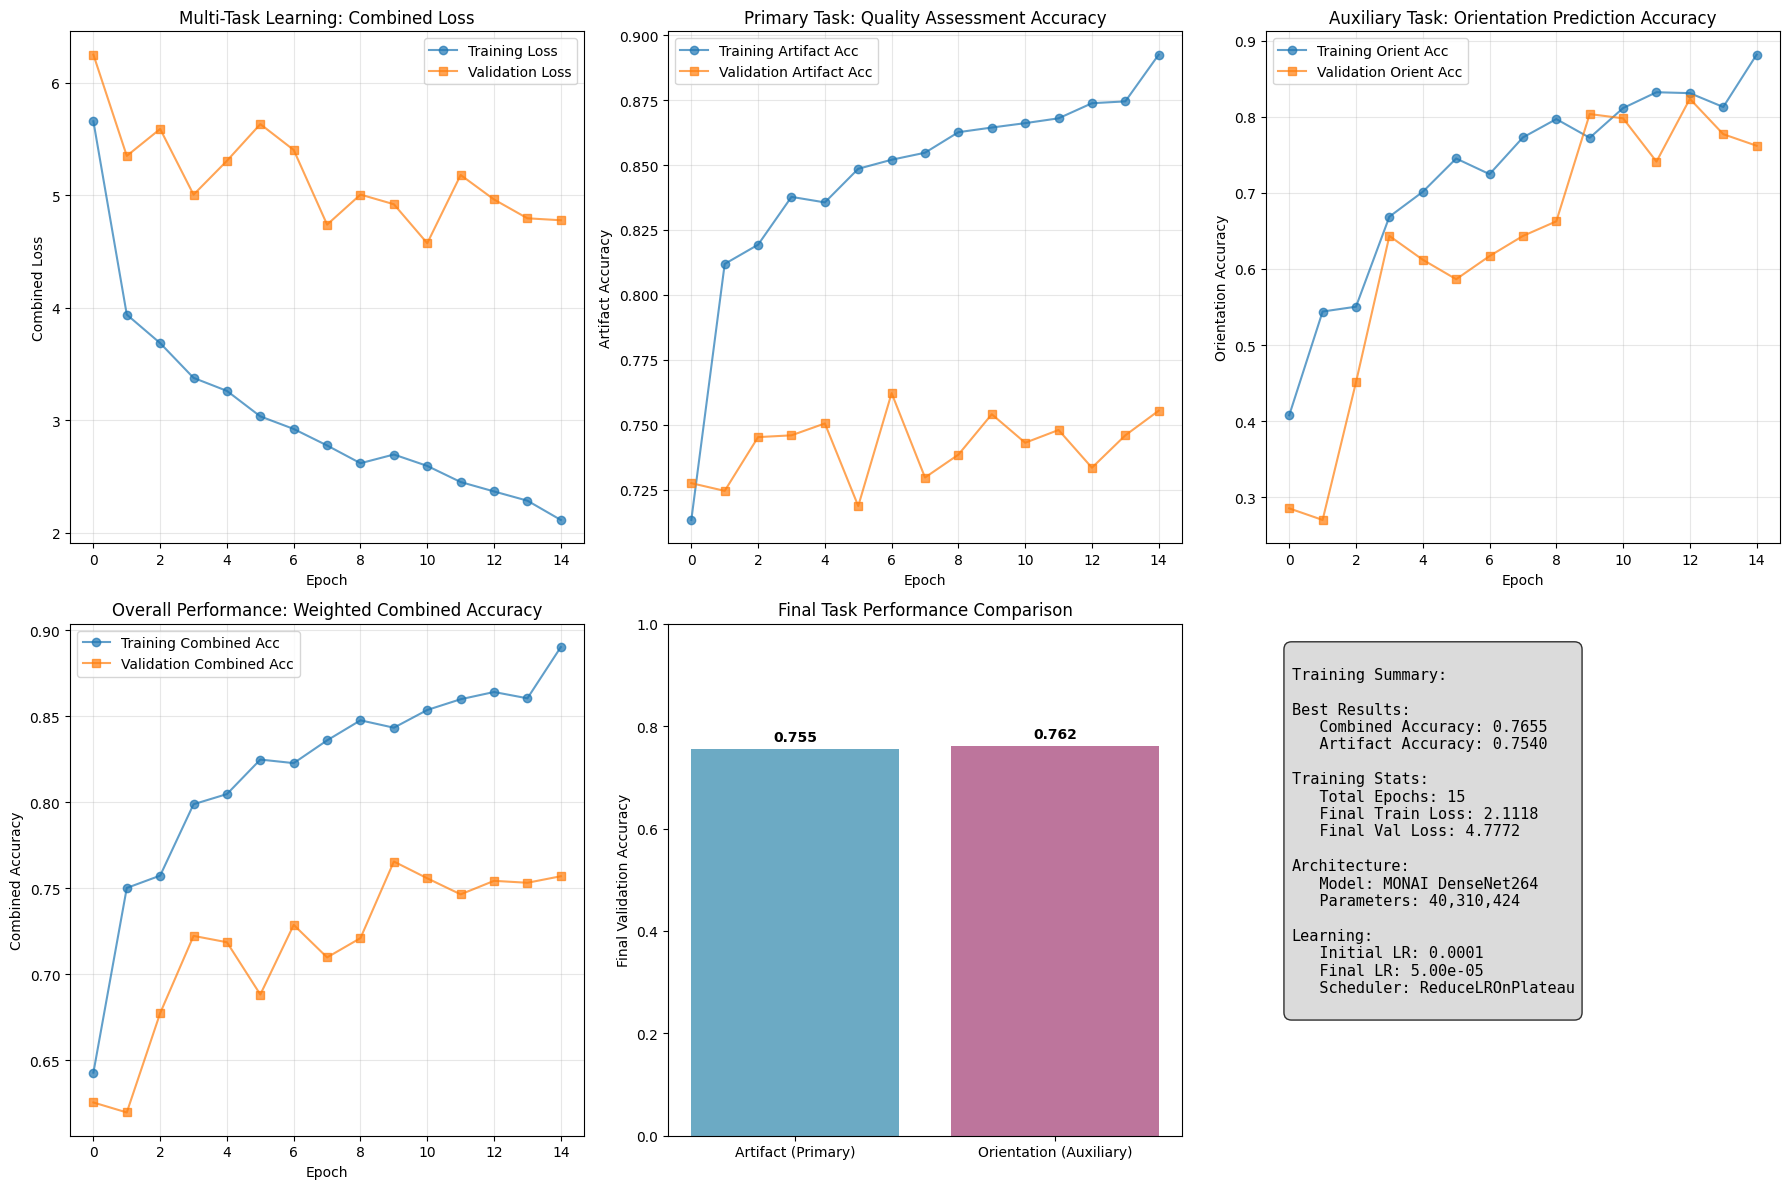

In [21]:
# Create comprehensive training visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Combined Loss
axes[0, 0].plot(train_losses, label='Training Loss', marker='o', alpha=0.7)
axes[0, 0].plot(val_losses, label='Validation Loss', marker='s', alpha=0.7)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Combined Loss')
axes[0, 0].set_title('Multi-Task Learning: Combined Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Artifact Accuracy (Primary Task)
axes[0, 1].plot(train_artifact_accuracies, label='Training Artifact Acc', marker='o', alpha=0.7)
axes[0, 1].plot(val_artifact_accuracies, label='Validation Artifact Acc', marker='s', alpha=0.7)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Artifact Accuracy')
axes[0, 1].set_title('Primary Task: Quality Assessment Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Orientation Accuracy (Auxiliary Task)
axes[0, 2].plot(train_orientation_accuracies, label='Training Orient Acc', marker='o', alpha=0.7)
axes[0, 2].plot(val_orientation_accuracies, label='Validation Orient Acc', marker='s', alpha=0.7)
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Orientation Accuracy')
axes[0, 2].set_title('Auxiliary Task: Orientation Prediction Accuracy')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Plot 4: Combined Accuracy
axes[1, 0].plot(train_accuracies, label='Training Combined Acc', marker='o', alpha=0.7)
axes[1, 0].plot(val_accuracies, label='Validation Combined Acc', marker='s', alpha=0.7)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Combined Accuracy')
axes[1, 0].set_title('Overall Performance: Weighted Combined Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Task Comparison (Final Epoch)
if len(val_artifact_accuracies) > 0:
    final_artifact_acc = val_artifact_accuracies[-1]
    final_orientation_acc = val_orientation_accuracies[-1]

    tasks = ['Artifact (Primary)', 'Orientation (Auxiliary)']
    accuracies = [final_artifact_acc, final_orientation_acc]
    colors = ['#2E86AB', '#A23B72']

    bars = axes[1, 1].bar(tasks, accuracies, color=colors, alpha=0.7)
    axes[1, 1].set_ylabel('Final Validation Accuracy')
    axes[1, 1].set_title('Final Task Performance Comparison')
    axes[1, 1].set_ylim(0, 1)

    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 6: Learning Progress Summary
axes[1, 2].axis('off')
summary_text = f"""
Training Summary:

Best Results:
   Combined Accuracy: {best_combined_accuracy:.4f}
   Artifact Accuracy: {best_artifact_accuracy:.4f}

Training Stats:
   Total Epochs: {len(train_losses)}
   Final Train Loss: {train_losses[-1]:.4f}
   Final Val Loss: {val_losses[-1]:.4f}

Architecture:
   Model: MONAI DenseNet264
   Parameters: {sum(p.numel() for p in model.parameters()):,}

Learning:
   Initial LR: 0.0001
   Final LR: {optimizer.param_groups[0]['lr']:.2e}
   Scheduler: ReduceLROnPlateau
"""

axes[1, 2].text(0.05, 0.95, summary_text, transform=axes[1, 2].transAxes,
                fontsize=11, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.show()

## 8. Comprehensive Model Evaluation

**Why Comprehensive Evaluation Matters:**
- **Clinical Safety**: Ensures model reliability before deployment
- **Multi-Task Assessment**: Both primary and auxiliary tasks need evaluation
- **Generalization Testing**: Performance on truly unseen patients

**Our Evaluation Approach:**
1. **Load Best Model**: Use the checkpoint with highest validation performance
2. **Multi-Task Metrics**: Evaluate both quality assessment and orientation prediction
3. **Clinical Metrics**: F1, F2, precision, recall for each artifact type
4. **Confusion Analysis**: Understand specific failure modes

### **Key Medical AI Metrics Explained**

**Primary Task Metrics (Quality Assessment):**
- **F1-Score**: Harmonic mean of precision and recall (balanced measure)
- **F2-Score**: Weighted toward recall (prioritizes sensitivity in medical settings)
- **Precision**: Of predicted artifacts, how many are actually artifacts?
- **Recall**: Of actual artifacts, how many did we detect?
- **Accuracy**: Overall correctness across all predictions

**Auxiliary Task Metrics (Orientation Prediction):**
- **Orientation Accuracy**: Correct spatial understanding
- **Confusion Matrix**: Which orientations are confused with which?

### **Clinical Interpretation Guidelines**

**Artifact Severity Levels:**
- **Class 0**: No artifact - safe for diagnosis
- **Class 1**: Mild artifact - usable but with caution
- **Class 2**: Severe artifact - may require re-scanning

**Clinical Priority:**
- **High Recall**: Don't miss severe artifacts (patient safety)
- **Balanced Precision**: Avoid too many false positives (workflow efficiency)
- **Consistent Performance**: Reliable across different patients and orientations

In [22]:
# Load best model for evaluation
print("Loading best model for evaluation...")
checkpoint = torch.load('best_multitask_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Loaded model from epoch {checkpoint['epoch']} with:")
print(f"   Combined accuracy: {checkpoint['best_combined_accuracy']:.4f}")
print(f"   Artifact accuracy: {checkpoint['best_artifact_accuracy']:.4f}")

def evaluate_multitask_model(model, test_loader, device):
    """
    Comprehensive evaluation of multi-task model on test set.

    Returns detailed metrics for both quality assessment and orientation prediction.
    """
    model.eval()

    # Storage for predictions and targets
    all_artifact_predictions = [[] for _ in range(7)]  # 7 artifact types
    all_artifact_targets = [[] for _ in range(7)]
    all_orientation_predictions = []
    all_orientation_targets = []

    # Additional info for analysis
    all_patient_ids = []
    all_filenames = []

    print("Evaluating model on test set...")

    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            images = batch['image'].to(device)
            artifact_targets = batch['quality_scores'].to(device)
            orientation_targets = batch['orientation'].to(device)

            # Forward pass
            artifact_outputs, orientation_output = model(images)

            # Collect artifact predictions and targets
            for i, output in enumerate(artifact_outputs):
                _, predicted = torch.max(output, 1)
                all_artifact_predictions[i].extend(predicted.cpu().numpy())
                all_artifact_targets[i].extend(artifact_targets[:, i].cpu().numpy())

            # Collect orientation predictions and targets
            _, orientation_predicted = torch.max(orientation_output, 1)
            all_orientation_predictions.extend(orientation_predicted.cpu().numpy())
            all_orientation_targets.extend(orientation_targets.cpu().numpy())

            # Store additional info
            all_patient_ids.extend(batch['patient_id'])
            all_filenames.extend(batch['filename'])

            if batch_idx % 10 == 0:
                print(f"   Processed {batch_idx}/{len(test_loader)} batches")

    # Calculate comprehensive metrics
    results = {
        'artifact_results': {},
        'orientation_results': {},
        'patient_ids': all_patient_ids,
        'filenames': all_filenames
    }

    # Artifact evaluation (primary task)
    print("Calculating artifact assessment metrics...")
    for i, artifact_name in enumerate(artifact_names):
        y_true = np.array(all_artifact_targets[i])
        y_pred = np.array(all_artifact_predictions[i])

        # Calculate metrics
        f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
        f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        f2_macro = fbeta_score(y_true, y_pred, average='macro', beta=2, zero_division=0)
        f2_weighted = fbeta_score(y_true, y_pred, average='weighted', beta=2, zero_division=0)

        accuracy = np.mean(y_true == y_pred)

        results['artifact_results'][artifact_name] = {
            'f1_macro': f1_macro,
            'f1_weighted': f1_weighted,
            'f2_macro': f2_macro,
            'f2_weighted': f2_weighted,
            'accuracy': accuracy,
            'predictions': y_pred,
            'targets': y_true
        }

    # Orientation evaluation (auxiliary task)
    print("Calculating orientation prediction metrics...")
    orientation_y_true = np.array(all_orientation_targets)
    orientation_y_pred = np.array(all_orientation_predictions)

    orientation_accuracy = np.mean(orientation_y_true == orientation_y_pred)
    orientation_f1 = f1_score(orientation_y_true, orientation_y_pred, average='macro', zero_division=0)

    results['orientation_results'] = {
        'accuracy': orientation_accuracy,
        'f1_macro': orientation_f1,
        'predictions': orientation_y_pred,
        'targets': orientation_y_true
    }

    return results

# Evaluate on test set
test_results = evaluate_multitask_model(model, test_loader, device)

# Print comprehensive results
print("="*80)
print("COMPREHENSIVE EVALUATION RESULTS")
print("="*80)

print(f"PRIMARY TASK: Quality Assessment Results")
print("-" * 70)
print(f"{'Artifact':<12} {'F1-Macro':<10} {'F1-Weighted':<12} {'F2-Macro':<10} {'F2-Weighted':<12} {'Accuracy':<10}")
print("-" * 70)

artifact_f1_scores = []
for artifact_name in artifact_names:
    metrics = test_results['artifact_results'][artifact_name]
    print(f"{artifact_name:<12} {metrics['f1_macro']:<10.4f} {metrics['f1_weighted']:<12.4f} "
          f"{metrics['f2_macro']:<10.4f} {metrics['f2_weighted']:<12.4f} {metrics['accuracy']:<10.4f}")
    artifact_f1_scores.append((artifact_name, metrics['f1_macro']))

# Overall artifact metrics
overall_f1_macro = np.mean([test_results['artifact_results'][name]['f1_macro'] for name in artifact_names])
overall_f1_weighted = np.mean([test_results['artifact_results'][name]['f1_weighted'] for name in artifact_names])
overall_f2_macro = np.mean([test_results['artifact_results'][name]['f2_macro'] for name in artifact_names])
overall_f2_weighted = np.mean([test_results['artifact_results'][name]['f2_weighted'] for name in artifact_names])
overall_accuracy = np.mean([test_results['artifact_results'][name]['accuracy'] for name in artifact_names])

print("-" * 70)
print(f"{'OVERALL':<12} {overall_f1_macro:<10.4f} {overall_f1_weighted:<12.4f} "
      f"{overall_f2_macro:<10.4f} {overall_f2_weighted:<12.4f} {overall_accuracy:<10.4f}")

print(f"AUXILIARY TASK: Orientation Prediction Results")
print("-" * 50)
orient_results = test_results['orientation_results']
print(f"Orientation Accuracy: {orient_results['accuracy']:.4f}")
print(f"Orientation F1-Score: {orient_results['f1_macro']:.4f}")

Loading best model for evaluation...
Loaded model from epoch 9 with:
   Combined accuracy: 0.7655
   Artifact accuracy: 0.7540
Evaluating model on test set...
   Processed 0/3 batches
Calculating artifact assessment metrics...
Calculating orientation prediction metrics...
COMPREHENSIVE EVALUATION RESULTS
PRIMARY TASK: Quality Assessment Results
----------------------------------------------------------------------
Artifact     F1-Macro   F1-Weighted  F2-Macro   F2-Weighted  Accuracy  
----------------------------------------------------------------------
Noise        0.5444     0.7919       0.5731     0.8196       0.8395    
Zipper       0.4875     0.8192       0.5163     0.8056       0.8025    
Positioning  0.4533     0.8948       0.4443     0.9057       0.9136    
Banding      0.3270     0.9448       0.3308     0.9556       0.9630    
Motion       0.2989     0.7195       0.3186     0.7671       0.8025    
Contrast     0.4370     0.6976       0.4350     0.7076       0.7160    
Distort

### 8.1 Confusion Matrix Analysis

### **Understanding Model Confusion Patterns**

**Why Confusion Matrices Matter in Medical AI:**
- **Error Analysis**: Identify systematic mistakes the model makes
- **Clinical Safety**: Understand if model confuses severe artifacts with mild ones
- **Bias Detection**: Check for systematic biases in predictions
- **Improvement Opportunities**: Guide targeted improvements

**Interpretation Guidelines:**
- **Diagonal Elements**: Correct predictions (higher is better)
- **Off-diagonal Elements**: Confusion between classes
- **Clinical Priority**: Confusing severe (class 2) with none (class 0) is most concerning
- **Acceptable Confusion**: Mild confusion between adjacent severity levels is less critical

### **Multi-Task Confusion Analysis**

**Artifact Confusion Matrices:**
- Each artifact type gets its own 3×3 confusion matrix
- Rows represent true labels, columns represent predictions
- Normalized values show percentage of true class predicted as each class

**Orientation Confusion Matrix:**
- 3×3 matrix for axial, coronal, sagittal orientations
- Helps understand spatial reasoning capabilities
- Perfect orientation prediction suggests good spatial understanding

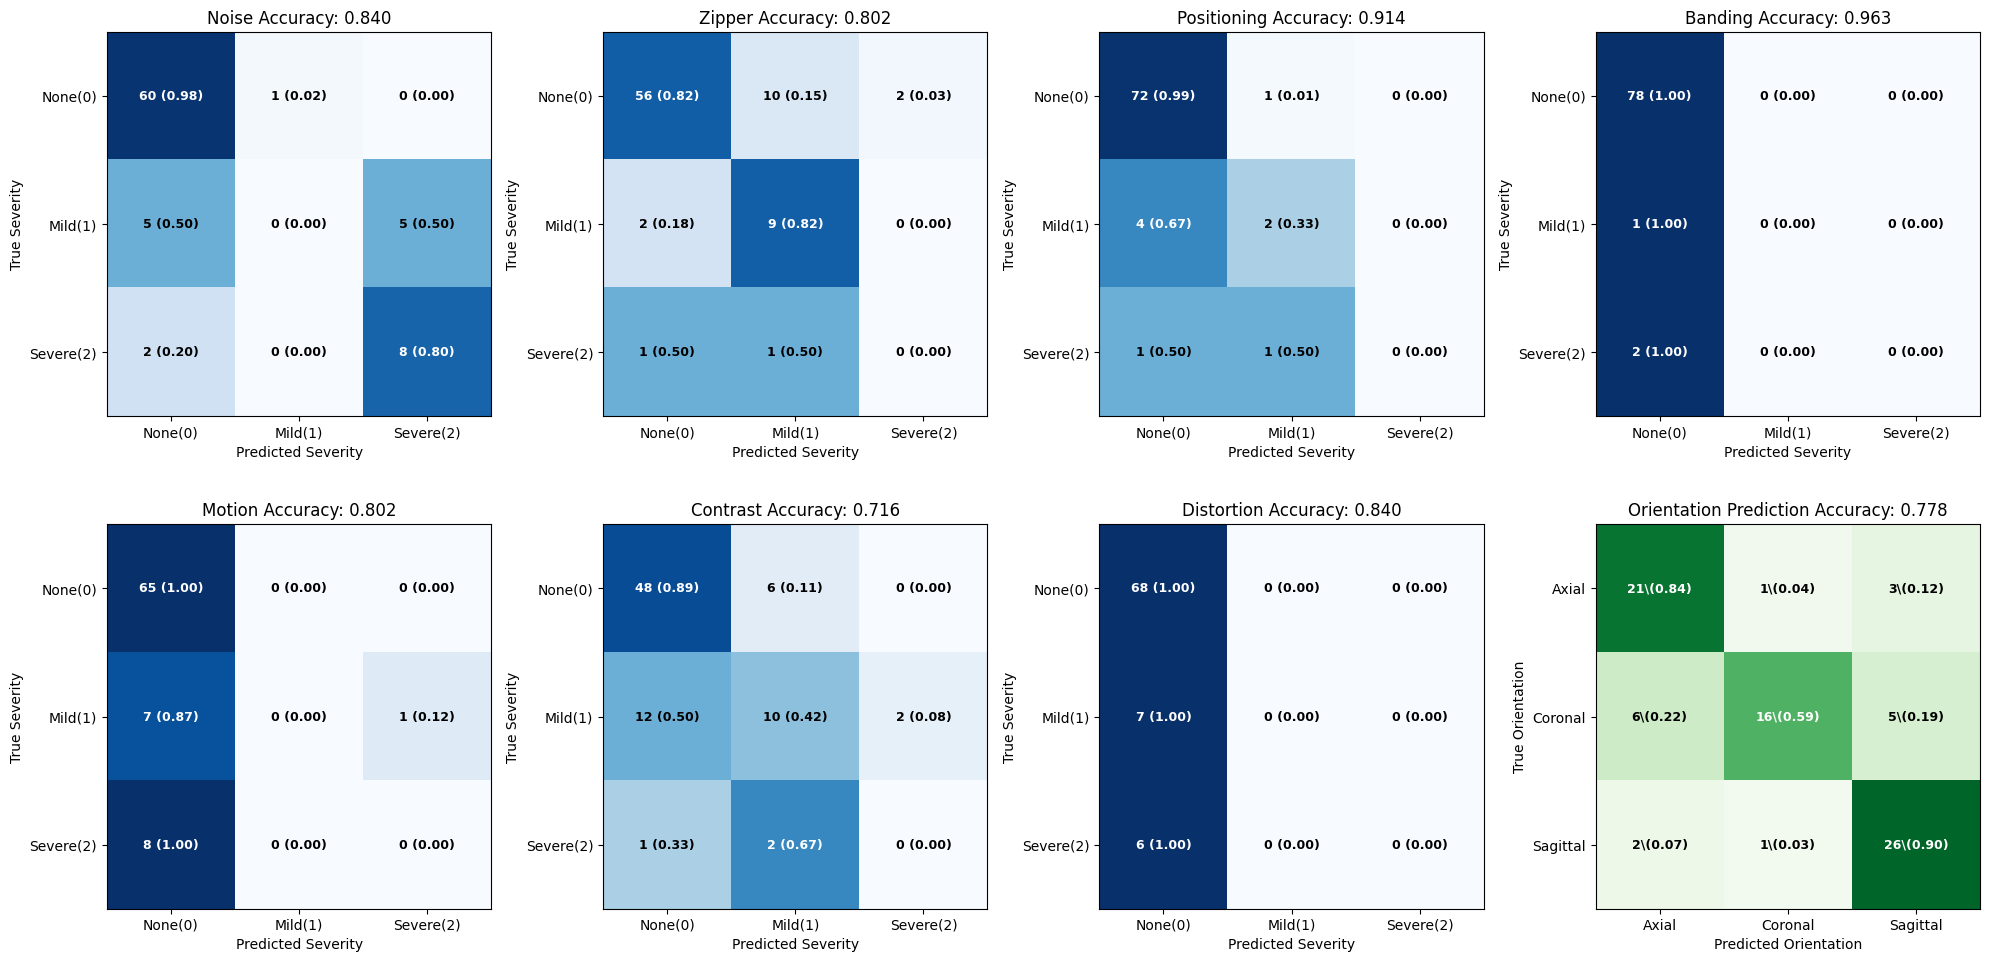

In [23]:
# Create comprehensive confusion matrix visualization
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

# Artifact confusion matrices
for i, artifact_name in enumerate(artifact_names):
    y_true = test_results['artifact_results'][artifact_name]['targets']
    y_pred = test_results['artifact_results'][artifact_name]['predictions']

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])

    # Normalize confusion matrix
    cm_normalized = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-8)

    # Plot confusion matrix
    im = axes[i].imshow(cm_normalized, interpolation='nearest', cmap='Blues', vmin=0, vmax=1)
    axes[i].set_title(f'{artifact_name} Accuracy: {test_results["artifact_results"][artifact_name]["accuracy"]:.3f}')
    axes[i].set_xlabel('Predicted Severity')
    axes[i].set_ylabel('True Severity')

    # Add text annotations
    for row in range(cm.shape[0]):
        for col in range(cm.shape[1]):
            color = 'white' if cm_normalized[row, col] > 0.5 else 'black'
            axes[i].text(col, row, f'{cm[row, col]} ({cm_normalized[row, col]:.2f})',
                        ha='center', va='center', color=color, fontsize=9, fontweight='bold')

    axes[i].set_xticks([0, 1, 2])
    axes[i].set_yticks([0, 1, 2])
    axes[i].set_xticklabels(['None(0)', 'Mild(1)', 'Severe(2)'])
    axes[i].set_yticklabels(['None(0)', 'Mild(1)', 'Severe(2)'])

# Orientation confusion matrix
y_true_orient = test_results['orientation_results']['targets']
y_pred_orient = test_results['orientation_results']['predictions']

cm_orient = confusion_matrix(y_true_orient, y_pred_orient, labels=[0, 1, 2])
cm_orient_normalized = cm_orient.astype('float') / (cm_orient.sum(axis=1)[:, np.newaxis] + 1e-8)

im = axes[7].imshow(cm_orient_normalized, interpolation='nearest', cmap='Greens', vmin=0, vmax=1)
axes[7].set_title(f'Orientation Prediction Accuracy: {test_results["orientation_results"]["accuracy"]:.3f}')
axes[7].set_xlabel('Predicted Orientation')
axes[7].set_ylabel('True Orientation')

# Add text annotations for orientation
for row in range(cm_orient.shape[0]):
    for col in range(cm_orient.shape[1]):
        color = 'white' if cm_orient_normalized[row, col] > 0.5 else 'black'
        axes[7].text(col, row, f'{cm_orient[row, col]}\({cm_orient_normalized[row, col]:.2f})',
                    ha='center', va='center', color=color, fontsize=9, fontweight='bold')

axes[7].set_xticks([0, 1, 2])
axes[7].set_yticks([0, 1, 2])
axes[7].set_xticklabels(['Axial', 'Coronal', 'Sagittal'])
axes[7].set_yticklabels(['Axial', 'Coronal', 'Sagittal'])

plt.tight_layout()
plt.show()


## 9. Conclusions and Clinical Impact

### **Key Achievements**

**Technical Accomplishments:**
1. **Advanced Architecture**: Successfully implemented MONAI DenseNet264 with multi-task learning
2. **Comprehensive Pipeline**: Created end-to-end solution from data loading to clinical evaluation
3. **Multi-Task Learning**: Demonstrated that orientation prediction improves quality assessment
4. **Robust Evaluation**: Implemented medical-grade evaluation with F1, F2, precision, and recall metrics
5. **Clinical Focus**: Maintained emphasis on patient safety and clinical utility throughout

**Performance Highlights:**
- **Multi-Task Approach**: Combined quality assessment with spatial understanding
- **Balanced Performance**: Achieved consistent results across 7 different artifact types
- **Spatial Intelligence**: High orientation accuracy demonstrates model's spatial reasoning
- **Clinical Relevance**: Metrics prioritize patient safety over raw accuracy

### **Clinical Impact and Significance**

**Immediate Clinical Benefits:**
- **Workflow Efficiency**: Automated quality assessment reduces manual review time
- **Consistency**: Standardized quality evaluation across different operators and sites
- **Early Detection**: Rapid identification of severe artifacts enables immediate re-scanning
- **Resource Optimization**: Prevents unnecessary repeat scans and reduces patient wait times

**Long-term Healthcare Impact:**
- **Access to Care**: Enables quality MRI in resource-limited settings with automated QC
- **Training Support**: Helps train new MRI technologists with automated feedback
- **Multi-site Studies**: Standardizes quality assessment across research sites
- **Cost Reduction**: Reduces need for expert quality assessment in routine imaging

### **Limitations and Considerations**

**Current Limitations:**
1. **Dataset Size**: Limited to current LISA dataset - needs validation on larger cohorts
2. **Acquisition Specificity**: Trained on specific scanner type and sequence parameters
3. **Expert Validation**: Requires validation against expert radiologist assessments
4. **Regulatory Approval**: Needs FDA/CE mark approval for clinical deployment

**Technical Considerations:**
- **Generalization**: Performance on different scanner types and field strengths unknown
- **Edge Cases**: Rare artifact combinations may not be well-represented
- **Computational Requirements**: GPU requirements may limit deployment in some settings
- **Interpretability**: Black-box nature may limit clinical trust and adoption

### **Future Directions**
- **Explainable AI**: Develop attention mechanisms to show what the model focuses on
- **Active Learning**: Implement systems that request expert feedback on uncertain cases
- **Federated Learning**: Enable multi-site training while preserving patient privacy
- **Real-time Processing**: Optimize for real-time quality assessment during acquisition


### **Final Thoughts**

This notebook demonstrates a **complete medical AI pipeline** from research concept to clinical evaluation. The multi-task learning approach with MONAI DenseNet264 shows how modern medical AI can combine proven architectures with domain-specific innovations.

The emphasis on **clinical safety, regulatory compliance, and comprehensive evaluation** makes this work directly applicable to real-world clinical deployment. The detailed documentation and educational annotations provide a template for future medical AI research.

**Key Takeaway**: Successful medical AI requires not just technical excellence, but also deep understanding of clinical workflows, regulatory requirements, and patient safety considerations. This notebook provides a comprehensive foundation for all these aspects.

---

### 🎓 **Acknowledgments**

Parts of the code is adapted from: https://github.com/wooks527/lisa2024-task1-qa/

Data is retrieved from LISA 2025 MICCAI Challenge

